# Import the Dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

**NOTE:** Since mostly I'm using plotly package. we can zoom on graphs for better visualisation.

# Loading Time Series of Global Cases

**Data Preprocessing**

In [2]:
confirm = pd.read_csv(r"time_series_covid19_confirmed_global.csv")
confirm.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571


In [3]:
death = pd.read_csv(r"time_series_covid19_deaths_global.csv")
death.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,826,864,898,920,936,957,971,994,1010,1012
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,74,76,79,81,83,83,85,89,93,95


In [4]:
recover = pd.read_csv(r"time_series_covid19_recovered_global.csv")
recover.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,19164,19366,20103,20179,20700,20847,20882,21135,21216,21254
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1637,1657,1702,1744,1791,1832,1875,1881,1946,2014


In [5]:
confirm_df = confirm.drop(['Province/State', 'Country/Region', 'Lat', 'Long'],axis=1).sum()
recover_df = recover.drop(['Province/State', 'Country/Region', 'Lat', 'Long'],axis=1).sum()
death_df = death.drop(['Province/State', 'Country/Region', 'Lat', 'Long'],axis=1).sum()

In [6]:
active_df = pd.Series( data = np.array([ x1-x2-x3 for (x1,x2,x3) in zip(confirm_df.values,recover_df.values,death_df.values)]),
                      index = confirm_df.index )

In [7]:
# Checking if any series has any null values
print(pd.DataFrame(confirm_df).info())
print("-------------x------------x-------------x----------")
print(pd.DataFrame(recover_df).info())
print("-------------x------------x-------------x----------")
print(pd.DataFrame(death_df).info())
print("-------------x------------x-------------x----------")
print(pd.DataFrame(active_df).info())

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 1/22/20 to 7/13/20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       174 non-null    int64
dtypes: int64(1)
memory usage: 2.7+ KB
None
-------------x------------x-------------x----------
<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 1/22/20 to 7/13/20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       174 non-null    int64
dtypes: int64(1)
memory usage: 2.7+ KB
None
-------------x------------x-------------x----------
<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 1/22/20 to 7/13/20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       174 non-null    int64
dtypes: int64(1)
memory usage: 2.7+ KB
None
-------------x------------x-------------x----------
<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 1/22/20 to 7

Every series has 174 enteries of 174 days and their are 174 non null values in each series.

# Forecasting

I'm going to generate a week ahead forecast of confirmed cases of COVID-19 using Prophet, with specific prediction intervals by creating a base model both without tweaking of seasonality-related parameters and additional regressors.

In [8]:
from fbprophet import Prophet

In [9]:
confirm_df = confirm_df.reset_index()
recover_df = recover_df.reset_index()
death_df = death_df.reset_index()
active_df = active_df.reset_index()

**The input to Prophet is always a data frame with two columns: ds and y**

## Model for predicting Confirmed Cases (Globally)

In [10]:
confirm_df.columns = ['ds','y']
confirm_df['ds'] = pd.to_datetime(confirm_df['ds'])
confirm_df.head()

,ds,y
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118


In [11]:
confirm_prophet = Prophet(interval_width=0.95) 
confirm_prophet.fit(confirm_df) 
confirm_future = confirm_prophet.make_future_dataframe(periods=7) 
confirm_future.tail()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
176,2020-07-16
177,2020-07-17
178,2020-07-18
179,2020-07-19
180,2020-07-20


In [12]:
#predicting the future with date, and upper and lower limit of y value
confirm_forecast = confirm_prophet.predict(confirm_future)
confirm_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2020-07-16,1.330397e+07,1.317379e+07,1.344691e+07
177,2020-07-17,1.348105e+07,1.332848e+07,1.363631e+07
178,2020-07-18,1.365352e+07,1.350265e+07,1.380373e+07
179,2020-07-19,1.381971e+07,1.367713e+07,1.397831e+07
180,2020-07-20,1.398281e+07,1.382404e+07,1.414408e+07


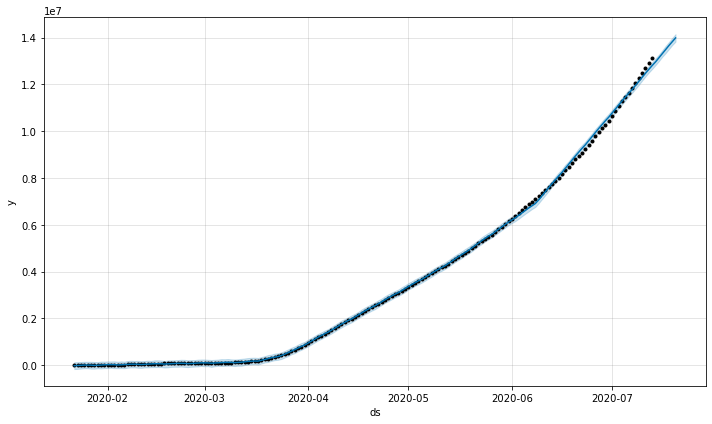

In [13]:
confirmed_forecast_plot = confirm_prophet.plot(confirm_forecast)

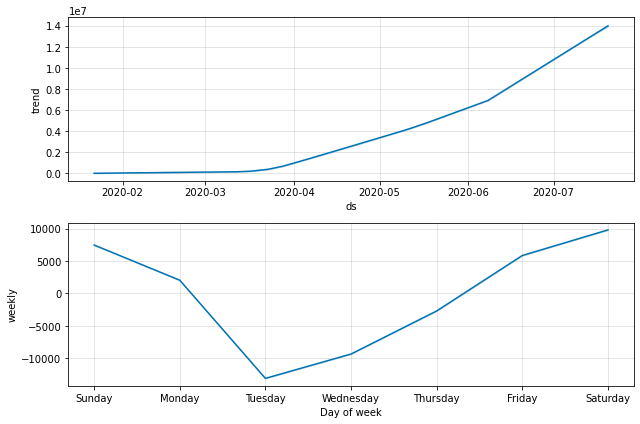

In [14]:
confirmed_forecast_plot_component = confirm_prophet.plot_components(confirm_forecast)

## Model for predicting Deaths Cases (Globally)

In [15]:
death_df.columns = ['ds','y']
death_df['ds'] = pd.to_datetime(death_df['ds'])

# Model with same parameter
death_prophet_model = Prophet(interval_width=0.95)
death_prophet_model.fit(death_df)

# To predict next 7 days value
death_future = death_prophet_model.make_future_dataframe(periods=7)
death_future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
176,2020-07-16
177,2020-07-17
178,2020-07-18
179,2020-07-19
180,2020-07-20


In [16]:
death_forecast = death_prophet_model.predict(death_future)
death_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2020-07-16,587961.483844,586310.732265,589687.091966
177,2020-07-17,593098.369783,590804.924649,595453.560993
178,2020-07-18,597662.489212,594802.809696,601082.004534
179,2020-07-19,601541.377676,597761.938687,605670.530062
180,2020-07-20,605609.150056,600677.424182,610593.297905


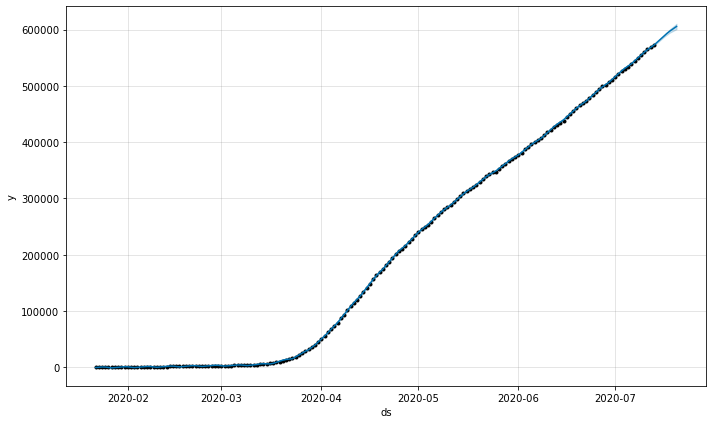

In [17]:
deaths_forecast_plot = death_prophet_model.plot(death_forecast)

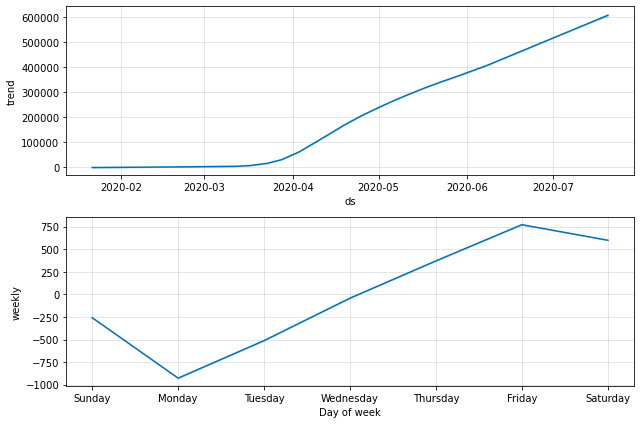

In [18]:
deaths_forecast_plot_component = death_prophet_model.plot_components(death_forecast)

## Model for predicting Recovered Cases (Globally)

In [19]:
recover_df.columns = ['ds','y']
recover_df['ds'] = pd.to_datetime(recover_df['ds'])

# Model with same parameter
recovered_prophet_model = Prophet(interval_width=0.95)
recovered_prophet_model.fit(recover_df)

# To predict next 7 days value
recovers_future = recovered_prophet_model.make_future_dataframe(periods=7)
recovers_future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
176,2020-07-16
177,2020-07-17
178,2020-07-18
179,2020-07-19
180,2020-07-20


In [20]:
recovers_forecast = recovered_prophet_model.predict(recovers_future)
recovers_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2020-07-16,7.362227e+06,7.233891e+06,7.496346e+06
177,2020-07-17,7.475832e+06,7.336952e+06,7.608312e+06
178,2020-07-18,7.591423e+06,7.461653e+06,7.729738e+06
179,2020-07-19,7.697403e+06,7.565704e+06,7.826280e+06
180,2020-07-20,7.810058e+06,7.670235e+06,7.944652e+06


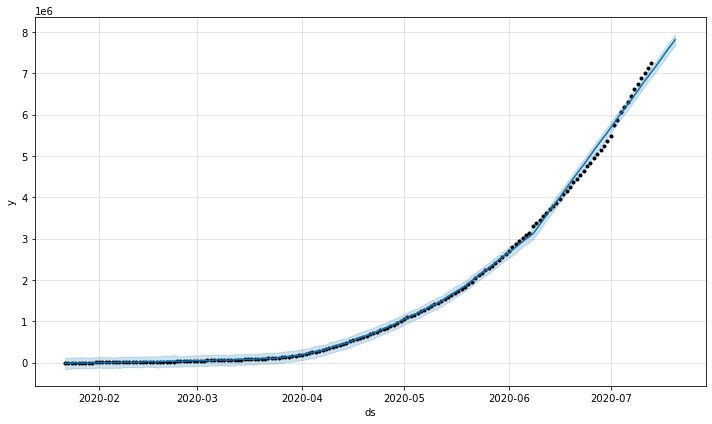

In [21]:
recovers_forecast_plot = recovered_prophet_model.plot(recovers_forecast)

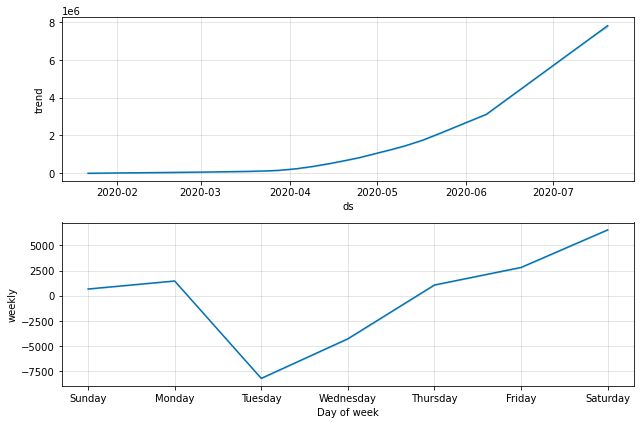

In [22]:
recovers_forecast_plot_component = recovered_prophet_model.plot_components(recovers_forecast)